# Ejemplo de Grafo de Visibilidad

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/6-Planificacion-Movimiento/6-02-Grafos-visibilidad.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# %matplotlib qt

### Clases complementarias

In [3]:
class ObstaclePolygon(object):
    """
    Polígonos que simulan obstáculos
    
    """
    def __init__(self, x_list, y_list):
        """
        x_list - coordenadas x del polígono
        y_list - coordenadas y del polígono
        """
        self.x_list = x_list
        self.y_list = y_list
        self.close_polygon()
        self.make_clockwise()

    def close_polygon(self):
        # Cerrar el polígono uniendo punto inicial y final
        is_x_same = self.x_list[0] == self.x_list[-1]
        is_y_same = self.y_list[0] == self.y_list[-1]
        # Si punto inicial y final coinciden, no se añade nada
        if is_x_same and is_y_same:
            return  # no es necesario añadir puntos
        # Añadir como punto final el punto inicial
        self.x_list.append(self.x_list[0])
        self.y_list.append(self.y_list[0])
        
    def make_clockwise(self):
        if not self.is_clockwise():
            self.x_list = list(reversed(self.x_list))
            self.y_list = list(reversed(self.y_list))

    def is_clockwise(self):
        n = len(self.x_list)
        eval_sum = sum([(self.x_list[i+1]-self.x_list[i]) *(self.y_list[i+1]+self.y_list[i])
                        for i in range(n-1)])
        eval_sum += (self.x_list[0]-self.x_list[n-1]) * (self.y_list[0]+self.y_list[n-1])
        return eval_sum >= 0

    def plot(self, facecolor='lightblue', edgecolor='blue'):
        plt.fill(self.x_list, self.y_list, facecolor=facecolor, edgecolor=edgecolor)

In [4]:
class Geometry:
    class Point:
        def __init__(self, x, y):
            self.x = x
            self.y = y

    @staticmethod
    def is_seg_intersect(p1, q1, p2, q2):

        def on_segment(p, q, r):
            if ((q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and
                    (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
                return True
            return False

        def orientation(p, q, r):
            val = (float(q.y - p.y) * (r.x - q.x)) - (
                    float(q.x - p.x) * (r.y - q.y))
            if val > 0:
                return 1
            if val < 0:
                return 2
            return 0

        # Find the 4 orientations required for
        # the general and special cases
        o1 = orientation(p1, q1, p2)
        o2 = orientation(p1, q1, q2)
        o3 = orientation(p2, q2, p1)
        o4 = orientation(p2, q2, q1)

        if (o1 != o2) and (o3 != o4):
            return True
        if (o1 == 0) and on_segment(p1, p2, q1):
            return True
        if (o2 == 0) and on_segment(p1, q2, q1):
            return True
        if (o3 == 0) and on_segment(p2, p1, q2):
            return True
        if (o4 == 0) and on_segment(p2, q1, q2):
            return True
        return False

### Clase para realizar búsqueda usando el algoritmo de DIjkstra

In [5]:
class DijkstraSearch:
    class Node:
        """
        Node class for dijkstra search
        """

        def __init__(self, x, y, cost=None, parent=None, edge_ids=None):
            self.x = x
            self.y = y
            self.cost = cost
            self.parent = parent
            self.edge_ids = edge_ids

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent)

    def __init__(self, show_animation=False):
        self.show_animation = show_animation

    def search_roadmap(self, start, goal, roadmap):
        rx, ry = self.search(S[0], S[1], G[0], G[1], 
                             [node.x for node in roadmap.nodes], 
                             [node.y for node in roadmap.nodes],
                             roadmap.road_map_info)
        return rx, ry
        
    def search(self, sx, sy, gx, gy, node_x, node_y, edge_ids_list):
        """
        Search shortest path
        s_x: start x positions [m]
        s_y: start y positions [m]
        gx: goal x position [m]
        gx: goal x position [m]
        node_x: node x position
        node_y: node y position
        edge_ids_list: edge_list each item includes a list of edge ids
        """
        start_node = self.Node(sx, sy, 0.0, -1)
        goal_node = self.Node(gx, gy, 0.0, -1)
        current_node = None

        open_set, close_set = dict(), dict()
        open_set[self.find_id(node_x, node_y, start_node)] = start_node

        while True:
            if self.has_node_in_set(close_set, goal_node):
                print("goal is found!")
                goal_node.parent = current_node.parent
                goal_node.cost = current_node.cost
                break
            elif not open_set:
                print("Cannot find path")
                break

            current_id = min(open_set, key=lambda o: open_set[o].cost)
            current_node = open_set[current_id]

            # show graph
            if self.show_animation and len(
                    close_set.keys()) % 2 == 0:  # pragma: no cover
                plt.plot(current_node.x, current_node.y, "xg")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect(
                    'key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
                plt.pause(0.1)

            # Remove the item from the open set
            del open_set[current_id]
            # Add it to the closed set
            close_set[current_id] = current_node

            # expand search grid based on motion model
            for i in range(len(edge_ids_list[current_id])):
                n_id = edge_ids_list[current_id][i]
                dx = node_x[n_id] - current_node.x
                dy = node_y[n_id] - current_node.y
                d = np.hypot(dx, dy)
                node = self.Node(node_x[n_id], node_y[n_id],
                                 current_node.cost + d, current_id)

                if n_id in close_set:
                    continue
                # Otherwise if it is already in the open set
                if n_id in open_set:
                    if open_set[n_id].cost > node.cost:
                        open_set[n_id] = node
                else:
                    open_set[n_id] = node

        # generate final course
        rx, ry = self.generate_final_path(close_set, goal_node)

        return rx, ry

    @staticmethod
    def generate_final_path(close_set, goal_node):
        rx, ry = [goal_node.x], [goal_node.y]
        parent = goal_node.parent
        while parent != -1:
            n = close_set[parent]
            rx.append(n.x)
            ry.append(n.y)
            parent = n.parent
        rx, ry = rx[::-1], ry[::-1]  # reverse it
        return rx, ry

    def has_node_in_set(self, target_set, node):
        for key in target_set:
            if self.is_same_node(target_set[key], node):
                return True
        return False

    def find_id(self, node_x_list, node_y_list, target_node):
        for i, _ in enumerate(node_x_list):
            if self.is_same_node_with_xy(node_x_list[i], node_y_list[i],
                                         target_node):
                return i
        return None

    @staticmethod
    def is_same_node_with_xy(node_x, node_y, node_b):
        dist = np.hypot(node_x - node_b.x,
                        node_y - node_b.y)
        return dist <= 0.1

    @staticmethod
    def is_same_node(node_a, node_b):
        dist = np.hypot(node_a.x - node_b.x,
                        node_b.y - node_b.y)
        return dist <= 0.1

### Clase para los grafos de visibilidad

In [6]:
class Node(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        

class VisibilityRoadMap(object):
    def __init__(self, robot_radius, obstacles, do_plot=True):
        self.robot_radius = robot_radius
        self.do_plot = do_plot
        self.obstacles = obstacles
        
    def generate(self, start, goal):
        self.start_x = start[0]
        self.start_y = start[1]
        self.goal_x = goal[0]
        self.goal_y = goal[1]
        # Add start and goal as nodes
        nodes = [Node(self.start_x, self.start_y), Node(self.goal_x, self.goal_y)]
        # Add vertices in configuration space as nodes
        for obstacle in self.obstacles:
            x_list, y_list = self.calc_vertices_in_configuration_space(obstacle.x_list, obstacle.y_list)
            for (vx, vy) in zip(x_list, y_list):
                nodes.append(Node(vx, vy))
        self.nodes = nodes
        self.road_map_info = self.generate_road_map_info()
        # Plot the nodes considering the robot radius
        for node in nodes:
            plt.plot(node.x, node.y, "xr")
    
    def calc_vertices_in_configuration_space(self, x_list, y_list):
        x_lst = x_list[0:-1]
        y_lst = y_list[0:-1]
        cvx_list, cvy_list = [], []
        n_data = len(x_lst)
        for index in range(n_data):
            offset_x, offset_y = self.calc_offset_xy(x_lst[index-1], y_lst[index-1],
                                                     x_lst[index], y_lst[index],
                                                     x_lst[(index+1) % n_data], 
                                                     y_lst[(index+1) % n_data] )
            cvx_list.append(offset_x)
            cvy_list.append(offset_y)
        return cvx_list, cvy_list

    def generate_road_map_info(self):
        nodes = self.nodes
        obstacles = self.obstacles
        road_map_info_list = []
        for target_node in nodes:
            road_map_info = []
            for node_id, node in enumerate(nodes):
                if np.hypot(target_node.x - node.x,
                            target_node.y - node.y) <= 0.1:
                    continue
                is_valid = True
                for obstacle in obstacles:
                    if not self.is_edge_valid(target_node, node, obstacle):
                        is_valid = False
                        break
                if is_valid:
                    road_map_info.append(node_id)
            road_map_info_list.append(road_map_info)
        return road_map_info_list

    @staticmethod
    def is_edge_valid(target_node, node, obstacle):

        for i in range(len(obstacle.x_list) - 1):
            p1 = Geometry.Point(target_node.x, target_node.y)
            p2 = Geometry.Point(node.x, node.y)
            p3 = Geometry.Point(obstacle.x_list[i], obstacle.y_list[i])
            p4 = Geometry.Point(obstacle.x_list[i + 1], obstacle.y_list[i + 1])

            if Geometry.is_seg_intersect(p1, p2, p3, p4):
                return False

        return True

    def calc_offset_xy(self, px, py, x, y, nx, ny):
        p_vec = np.arctan2(y-py, x-px)
        n_vec = np.arctan2(ny-y, nx-x)
        offset_vec = np.arctan2(np.sin(p_vec)+np.sin(n_vec), np.cos(p_vec) + np.cos(n_vec)) + np.pi/2.0
        offset_x = x + self.robot_radius * np.cos(offset_vec)
        offset_y = y + self.robot_radius * np.sin(offset_vec)
        return offset_x, offset_y

    def plot(self):
        for i, node in enumerate(self.nodes):
            for index in self.road_map_info[i]:
                plt.plot([node.x, self.nodes[index].x], 
                         [node.y, self.nodes[index].y], 
                         color = "y", linewidth=1.0)

## Programa principal

In [7]:
# Posición inicial y final
S = (10.0, 10.0)  # Start
G = (50.0, 50.0)  # Goal

# Geometría del robot
radio_robot = 0.5 # 5.0
# Posiciones de los obstáculos (polígonos)
obstaculos = [ObstaclePolygon([20.0, 30.0, 15.0], [20.0, 20.0, 30.0]), 
              ObstaclePolygon([40.0, 45.0, 50.0, 40.0], [50.0, 40.0, 20.0, 40.0]),
              ObstaclePolygon([20.0, 30.0, 30.0, 20.0], [40.0, 45.0, 60.0, 50.0]) ]

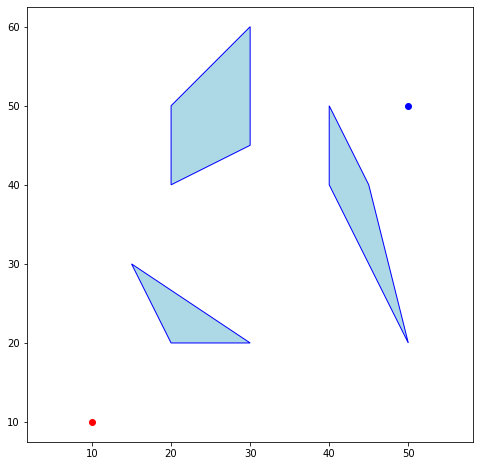

In [8]:
# Graficar punto de inicio (start) y punto objetivo (goal)
plt.figure(figsize=(8,8))
plt.plot(S[0], S[1], "or")
plt.plot(G[0], G[1], "ob")

# Graficar los obstáculos
for obstaculo in obstaculos:
    obstaculo.plot()
plt.axis("equal")
plt.pause(1.0)
plt.show()

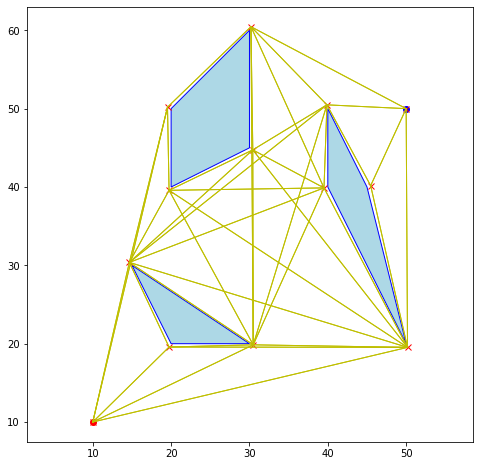

In [9]:
# Graficar punto de inicio (start) y punto objetivo (goal)
plt.figure(figsize=(8,8))
plt.plot(S[0], S[1], "or")
plt.plot(G[0], G[1], "ob")

# Graficar los obstáculos
for obstaculo in obstaculos:
    obstaculo.plot()
plt.axis("equal")

# Inicialización del modelo
roadmap = VisibilityRoadMap(radio_robot, obstaculos)
# Generación del grafo de visibilidad
roadmap.generate(S, G)
# Ploteo del grafo de visibilidad
roadmap.plot()

plt.show()

goal is found!


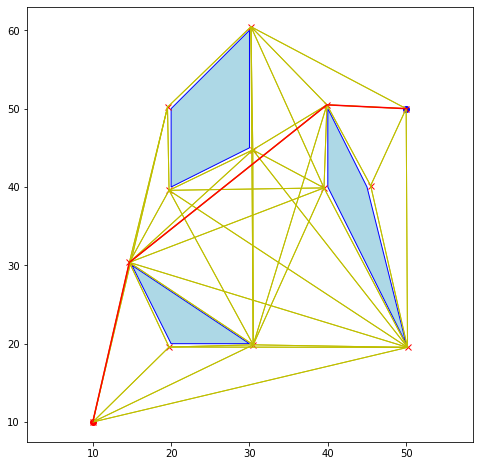

In [10]:
# Graficar punto de inicio (start) y punto objetivo (goal)
plt.figure(figsize=(8,8))
plt.plot(S[0], S[1], "or")
plt.plot(G[0], G[1], "ob")

# Graficar los obstáculos
for obstaculo in obstaculos:
    obstaculo.plot()
plt.axis("equal")

# Inicialización del modelo
roadmap = VisibilityRoadMap(radio_robot, obstaculos)
# Generación del grafo de visibilidad
roadmap.generate(S, G)
# Ploteo del grafo de visibilidad
roadmap.plot()

# Planificación del movimiento
planificador = DijkstraSearch()
traj_x, traj_y = planificador.search_roadmap(S, G, roadmap)

plt.plot(traj_x, traj_y, "-r")
plt.pause(0.5)
plt.show()